# Seattle Airbnb Data

The data I used in this notebook refer to over 3800 accommodations that where enlisted to Airbnb in Seattle during 2016. They describe a wide variety of features: not only information about hosts, locations and fares applied to each listing, but also their average ratings and availability period. These datasets are available for free download at https://www.kaggle.com/datasets/airbnb/seattle, where you can find more details and other interesting studies about them.

#### CRISP-DM process

1. **Business Understanding**

    These were the questions I decided to explore in the dataset:
    - How much ratings depend on prices and availability?
    - How much ratings depend on prices?
    - How much ratings depend on availability?
    
    </br>
    The whole notebook is aimed to answer the first question, while there are two specific paragraphs dedicated to discuss each of the two other questions.
</br>

2. **Data Understanding**

    Here I used the Seattle Airbnb ***linstings.csv** and ***calendar.csv*** datasets to attempt to answer our questions of interest. 
    
    In the paragraph **Data Exploration** I extracted some general information about the datasets structure and I computed some straight-forward statistics about their content.
    
    </br>
    
    From the large amount of fields available in the ***listing*** dataset a small subset of columns has been used containing information about ratings.
    
    Further steps of data exploration where performed in the paragraph ***Transform quantitative columns in categorical*** in order to undestad how to define non-skewed price and availability tiers.
    
</br>

3. **Prepare Data**
    
    The data preparation process is performed as follows:
    - in the paragraph **Data Quality** fileds types are modified in order to fit better their content
    - in the paragraph **Grouping and Merging Datasets** the two original datasets are merged and the data are aggregated to a granularity that is more useful in aswering the business questions
    - in the paragraph **Pre-Processing** records corresponding to missing ratings are removed from the dataset and price and availability tiers are defined from corresponding numerical fiedls.

</br>

4. **Model Data**

    In order to answer the questions which are dealt with in this notebook, it wasn't necessary to implement advanced model. In each paragraph, results are obtained by computing visuals that underline the relation between the considered fields.

</br>

5. **Results and Deploy**
   
   Results of the analysis performed in this notebook are duscussed in the post available [here](https://medium.com/@karlin.giordana/how-can-you-improve-your-ratings-as-airbnb-host-17c25338103f).

## How much ratings depend on prices and availability?

Second, I wonder if the price required for a one-night stay affects ratings scores. Do guests evaluate cheaper rooms worse or do them enjoy discount fares?  

### Imports

Read the necessary libraries and import data from ***listings.csv*** and ***calendar.csv*** files

##### Import Python Libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

##### Import Datasets

In [2]:
df_listings = pd.read_csv('../data/listings.csv')
df_listings.head()

id                           listing_url       scrape_id last_scraped  \
0   241032   https://www.airbnb.com/rooms/241032  20160104002432   2016-01-04   
1   953595   https://www.airbnb.com/rooms/953595  20160104002432   2016-01-04   
2  3308979  https://www.airbnb.com/rooms/3308979  20160104002432   2016-01-04   
3  7421966  https://www.airbnb.com/rooms/7421966  20160104002432   2016-01-04   
4   278830   https://www.airbnb.com/rooms/278830  20160104002432   2016-01-04   

                                  name  \
0         Stylish Queen Anne Apartment   
1   Bright & Airy Queen Anne Apartment   
2  New Modern House-Amazing water view   
3                   Queen Anne Chateau   
4       Charming craftsman 3 bdm house   

                                             summary  \
0                                                NaN   
1  Chemically sensitive? We've removed the irrita...   
2  New modern house built in 2013.  Spectacular s...   
3  A charming apartment that sits atop Queen Anne...   
4  Cozy family craftman house in beautiful neighb...   

                                               space  \
0  Make your self at home in this charming one-be...   
1  Beautiful, hypoallergenic apartment in an extr...   
2  Our house is modern, light and fresh with a wa...   
3                                                NaN   
4  Cozy family craftman house in beautiful neighb...   

                                         description experiences_offered  \
0  Make your self at home in this charming one-be...                none   
1  Chemically sensitive? We've removed the irrita...                none   
2  New modern house built in 2013.  Spectacular s...                none   
3  A charming apartment that sits atop Queen Anne...                none   
4  Cozy family craftman house in beautiful neighb...                none   

                               neighborhood_overview  \
0                                                NaN   
1  Queen Anne is a wonderful, truly functional vi...   
2  Upper Queen Anne is a charming neighborhood fu...   
3                                                NaN   
4  We are in the beautiful neighborhood of Queen ...   

                                               notes  \
0                                                NaN   
1  What's up with the free pillows?  Our home was...   
2  Our house is located just 5 short blocks to To...   
3                                                NaN   
4                                          Belltown    

                                             transit  \
0                                                NaN   
1  Convenient bus stops are just down the block, ...   
2  A bus stop is just 2 blocks away.   Easy bus a...   
3                                                NaN   
4  The nearest public transit bus (D Line) is 2 b...   

                                       thumbnail_url  \
0                                                NaN   
1  https://a0.muscache.com/ac/pictures/14409893/f...   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                          medium_url  \
0                                                NaN   
1  https://a0.muscache.com/im/pictures/14409893/f...   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                         picture_url  \
0  https://a1.muscache.com/ac/pictures/67560560/c...   
1  https://a0.muscache.com/ac/pictures/14409893/f...   
2  https://a2.muscache.com/ac/pictures/b4324e0f-a...   
3  https://a0.muscache.com/ac/pictures/94146944/6...   
4  https://a1.muscache.com/ac/pictures/6120468/b0...   

                                      xl_picture_url   host_id  \
0                                                

In [3]:
df_calendar = pd.read_csv('../data/calendar.csv')
df_calendar.head()

listing_id        date available   price
0      241032  2016-01-04         t  $85.00
1      241032  2016-01-05         t  $85.00
2      241032  2016-01-06         f     NaN
3      241032  2016-01-07         f     NaN
4      241032  2016-01-08         f     NaN

#### Definition of functions

Here I define some functions that I use in the following paragraphs in order to use the DRY principle

In [4]:
def data_exploration(df):
    '''Takes in a Data Frame df.
Prints its shape.
Returns a Data Frame whose index is the list of the input DF fields with a column with % of missing values'''
    
    print("The Data Frame has " + str(df.shape[0]) + " rows")
    print("The Data Frame has " + str(df.shape[1]) + " columns")

    df_output = pd.DataFrame(df.isnull().mean(), columns=['% of null values'])

    return df_output

In [5]:
print(data_exploration.__doc__)

Takes in a Data Frame df.
Prints its shape.
Returns a Data Frame whose index is the list of the input DF fields with a column with % of missing values


In [6]:
def remove_missing_bycol(df, column_names):
    '''Takes in a Data Frame (df) and a list of strings (column_names).
Returns a Data Frame without records with missing values in the inputed columns'''
    
    df_output = df.dropna(subset = column_names)
    
    return df_output

In [7]:
print(remove_missing_bycol.__doc__)

Takes in a Data Frame (df) and a list of strings (column_names).
Returns a Data Frame without records with missing values in the inputed columns


In [8]:
def plot_hist(df, col, n_bins, x_label, y_label):
    '''Takes in a Data Frame (df), an int value (n_bins) and 3 strings (col, x_label and y_label).
Plots a histogram for the input column col of the dataframe df with the specified number of bins and axis labels.
Returns the plot object'''
    
    ax = df[col].hist(bins=n_bins);
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    return ax

In [9]:
print(plot_hist.__doc__)

Takes in a Data Frame (df), an int value (n_bins) and 3 strings (col, x_label and y_label).
Plots a histogram for the input column col of the dataframe df with the specified number of bins and axis labels.
Returns the plot object


In [10]:
def group_by_col(df, col_by, col_togroup, grouping_criterium):
    '''Takes in a Data Frame (df), 3 list of strings (col_by, col_togroup and grouping_criterium).
Returns a Data Frame whose index are the values on which the data is grouped by with:
- a column for each grouped column with the specified aggregation criterium for the category
- a column for each grouped column with the gap between the mean for the category and the average value on all dataset
- a column for each grouped column with the number of records for the category'''
    
    
    df_output = pd.DataFrame(df.groupby(col_by).aggregate(dict(zip(col_togroup, grouping_criterium))))
    avg = df[col_togroup].mean()
    df_output['gap'] = df_output - avg
    df_output['listings_number'] = df.groupby(col_by)[col_togroup].count()
    
    return df_output

In [11]:
print(group_by_col.__doc__)

Takes in a Data Frame (df), 3 list of strings (col_by, col_togroup and grouping_criterium).
Returns a Data Frame whose index are the values on which the data is grouped by with:
- a column for each grouped column with the specified aggregation criterium for the category
- a column for each grouped column with the gap between the mean for the category and the average value on all dataset
- a column for each grouped column with the number of records for the category


In [12]:
def barplot(df, y_col, y_lim_min, y_lim_max, x_label, y_label):
    '''Takes in a Data Frame (df), 4 strings (y_col, r_y_col, y_label and r_y_label).
Plots a bar plot with
- values of y_col as y
- y_lim_min, y_lim_max as limits of y axis
- x_label as label for x axis
- y_label as label for x axis
Returns the plot object'''
    
    ax = df.plot.bar(y = y_col, legend=False)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_ylim(y_lim_min,y_lim_max)
    
    return ax

In [13]:
print(barplot.__doc__)

Takes in a Data Frame (df), 4 strings (y_col, r_y_col, y_label and r_y_label).
Plots a bar plot with
- values of y_col as y
- y_lim_min, y_lim_max as limits of y axis
- x_label as label for x axis
- y_label as label for x axis
Returns the plot object


### Data Exploration

##### Listings Dataset

In [14]:
data_exploration(df_listings)

The Data Frame has 3818 rows
The Data Frame has 92 columns


% of null values
id                                        0.000000
listing_url                               0.000000
scrape_id                                 0.000000
last_scraped                              0.000000
name                                      0.000000
summary                                   0.046359
space                                     0.149031
description                               0.000000
experiences_offered                       0.000000
neighborhood_overview                     0.270299
notes                                     0.420639
transit                                   0.244631
thumbnail_url                             0.083814
medium_url                                0.083814
picture_url                               0.000000
xl_picture_url                            0.083814
host_id                                   0.000000
host_url                                  0.000000
host_name                                 0.000524
host_since                                0.000524
host_location                             0.002095
host_about                                0.224987
host_response_time                        0.136983
host_response_rate                        0.136983
host_acceptance_rate                      0.202462
host_is_superhost                         0.000524
host_thumbnail_url                        0.000524
host_picture_url                          0.000524
host_neighbourhood                        0.078575
host_listings_count                       0.000524
host_total_listings_count                 0.000524
host_verifications                        0.000000
host_has_profile_pic                      0.000524
host_identity_verified                    0.000524
street                                    0.000000
neighbourhood                             0.108958
neighbourhood_cleansed                    0.000000
neighbourhood_group_cleansed              0.000000
city                                      0.000000
state                                     0.000000
zipcode                                   0.001833
market                                    0.000000
smart_location                            0.000000
country_code                              0.000000
country                                   0.000000
latitude                                  0.000000
longitude                                 0.000000
is_location_exact                         0.000000
property_type                             0.000262
room_type                                 0.000000
accommodates                              0.000000
bathrooms                                 0.004191
bedrooms                                  0.001572
beds                                      0.000262
bed_type                                  0.000000
amenities                                 0.000000
square_feet                               0.974594
price                                     0.000000
weekly_price                              0.473808
monthly_price                             0.602672
security_deposit                          0.511262
cleaning_fee                              0.269775
guests_included                           0.000000
extra_people                              0.000000
minimum_nights                            0.000000
maximum_nights                            0.000000
calendar_updated                          0.000000
has_availability                          0.000000
availability_30                           0.000000
availability_60                           0.000000
availability_90                           0.000000
availability_365                          0.000000
calendar_last_scraped                     0.000000
number_of_reviews                         0.000000
first_review                              0.164222
last_review                               0.164222
review_scores_rating                      0.169460
review_scores_accuracy                    0.172342
revie

##### Calendar Dataset

In [15]:
data_exploration(df_calendar)

The Data Frame has 1393570 rows
The Data Frame has 4 columns


% of null values
listing_id           0.00000
date                 0.00000
available            0.00000
price                0.32939

### Data Quality

##### Listings Dataset

Select from **listings** dataset the fields:
- review_scores_rating (where ratings are stored)
- id (necessary to merge with **calendar** dataset)

In [16]:
df_listings_subset = df_listings[['id', 'review_scores_rating']]

##### Calendar Dataset

All fields in **calendar**
In order to compare rating to price is firt necessary to transform data in price field in numeric format dataset as useful for our study

In order to use the **price** field is first necessary to transform data in price field in numeric format

In [17]:
df_calendar['price'] = df_calendar['price'].replace(regex=[r'\$', r','], value='').astype('float64')

Since the availability record stored in the field **available**, while being logically boolean is indeed a string, we have to convert is format by encoding

In [18]:
df_calendar['available'] = pd.get_dummies(df_calendar['available'], drop_first=True)

Grouping and Merging Datasets### Grouping and Merging Datasets

Since the day by day record for listings is out of the scope of our analysis, we group the data in **calendar** dataset by listing.

Then we merge both dataset using **listing_id** as key for the merge.

In [19]:
df_availability = df_calendar.groupby(by = ['listing_id']).sum()
df_availability['price'] = df_availability['price']/df_availability['available']
df_availability

C:\Users\2100\AppData\Local\Temp\ipykernel_6156\1496103261.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_availability = df_calendar.groupby(by = ['listing_id']).sum()


available       price
listing_id                       
3335              309  120.000000
4291              365   82.000000
5682              309   53.944984
6606              365   92.849315
7369               53   85.000000
...               ...         ...
10332096          365   40.000000
10334184          361  120.000000
10339144            0         NaN
10339145          365  237.904110
10340165          358   43.000000

[3818 rows x 2 columns]

In [20]:
df_merged = df_listings_subset.merge(df_availability, how = 'left', left_on='id', right_on='listing_id')

In [21]:
df_merged.head()

id  review_scores_rating  available        price
0   241032                  95.0        346    85.000000
1   953595                  96.0        291   170.931271
2  3308979                  97.0        220  1301.818182
3  7421966                   NaN        143   100.000000
4   278830                  92.0        365   462.739726

### Pre-Processing

#### Remove records with average rating missing

Since we are interested in studying the rating scores of the listings, we can remove from the dataset all listings that are not rated

In [22]:
data_exploration(df_merged)

The Data Frame has 3818 rows
The Data Frame has 4 columns


% of null values
id                            0.000000
review_scores_rating          0.169460
available                     0.000000
price                         0.024882

In [23]:
df_rated = remove_missing_bycol(df_merged, ['review_scores_rating'])

#### Transform quantitative columns in categorical

Since our aim is to study if in general prices and availability have some influence on the rating scores, we must deal with these dimesions as categorical variables.

##### Price

In order to store price data in a categorical column I split the listings in 15 tiers of price.

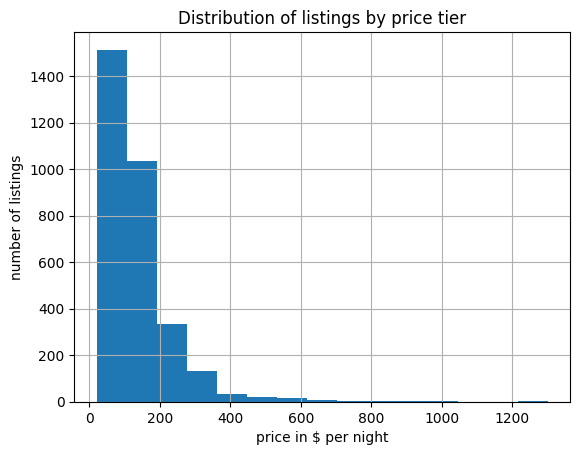

In [24]:
plot_hist(df_rated, 'price', 15, "price in $ per night", "number of listings")
plt.title("Distribution of listings by price tier");

As the distiribution of listings on the price tiers is very skewed toward lower values, I grouped in an only tier all listings with prices higher than 300$ per night 

In [25]:
df_rated['capped_price'] = pd.DataFrame({'col1': df_rated['price'], 'col2': [300 for i in df_rated.index]}).min(axis=1)

C:\Users\2100\AppData\Local\Temp\ipykernel_6156\3337026897.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rated['capped_price'] = pd.DataFrame({'col1': df_rated['price'], 'col2': [300 for i in df_rated.index]}).min(axis=1)


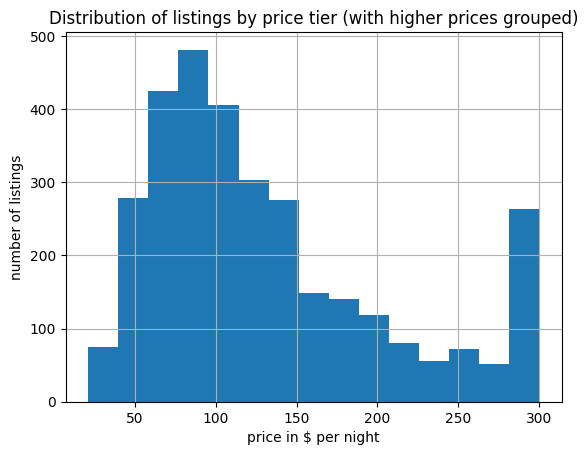

In [26]:
plot_hist(df_rated, 'capped_price', 15, "price in $ per night", "number of listings")
plt.title("Distribution of listings by price tier (with higher prices grouped)");

Define the price tiers and add the new categorical field to the dataset

In [27]:
df_rated['price_tiers'] = pd.DataFrame({'col1': (df_rated['price']//20)*20, 'col2': [300 for i in df_rated.index]}).min(axis=1)

C:\Users\2100\AppData\Local\Temp\ipykernel_6156\601027128.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rated['price_tiers'] = pd.DataFrame({'col1': (df_rated['price']//20)*20, 'col2': [300 for i in df_rated.index]}).min(axis=1)


In [28]:
df_rated['price_tiers'] = (df_rated['price_tiers'].astype(int).astype(str) + " $").str.zfill(5)

C:\Users\2100\AppData\Local\Temp\ipykernel_6156\2474955071.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rated['price_tiers'] = (df_rated['price_tiers'].astype(int).astype(str) + " $").str.zfill(5)


##### Availability

In order to store availability data in a categorical column I split the listings in 12 tiers of availability.

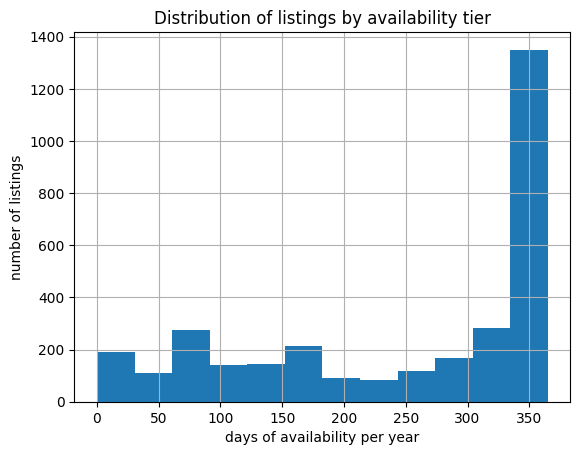

In [29]:
plot_hist(df_rated, 'available', 12, "days of availability per year", "number of listings")
plt.title("Distribution of listings by availability tier");

Define the availability tiers and add the new categorical field to the dataset

In [30]:
df_rated['availability_tiers'] = pd.DataFrame({'col1': df_rated['available']//30*30, 'col2': [360 for i in df_rated.index]}).min(axis=1)

C:\Users\2100\AppData\Local\Temp\ipykernel_6156\1186337729.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rated['availability_tiers'] = pd.DataFrame({'col1': df_rated['available']//30*30, 'col2': [360 for i in df_rated.index]}).min(axis=1)


In [31]:
df_rated['availability_tiers'] = (df_rated['availability_tiers'].astype(int).astype(str) + " days per year").str.zfill(17)

C:\Users\2100\AppData\Local\Temp\ipykernel_6156\1431809021.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rated['availability_tiers'] = (df_rated['availability_tiers'].astype(int).astype(str) + " days per year").str.zfill(17)


In [32]:
df_rated

id  review_scores_rating  available        price  capped_price  \
0      241032                  95.0        346    85.000000     85.000000   
1      953595                  96.0        291   170.931271    170.931271   
2     3308979                  97.0        220  1301.818182    300.000000   
4      278830                  92.0        365   462.739726    300.000000   
5     5956968                  95.0        302   125.629139    125.629139   
...       ...                   ...        ...          ...           ...   
3810   262764                  92.0        227   191.651982    191.651982   
3811  8578490                 100.0        221    67.782805     67.782805   
3812  3383329                  96.0        287   102.818815    102.818815   
3813  8101950                  80.0         32   359.000000    300.000000   
3814  8902327                 100.0        273   100.201465    100.201465   

     price_tiers availability_tiers  
0          080 $  330 days per year  
1          160 $  270 days per year  
2          300 $  210 days per year  
4          300 $  360 days per year  
5          120 $  300 days per year  
...          ...                ...  
3810       180 $  210 days per year  
3811       060 $  210 days per year  
3812       100 $  270 days per year  
3813       300 $  030 days per year  
3814       100 $  270 days per year  

[3171 rows x 7 columns]

### How much ratings depend on prices?

Define a dataframe to store statistics for each price tier.

In [33]:
avg_rating_by_price = group_by_col(df_rated, ['price_tiers'], ['review_scores_rating'], ['mean'])
avg_rating_by_price

review_scores_rating       gap  listings_number
price_tiers                                                 
020 $                   93.200000 -1.339262               75
040 $                   94.013115 -0.526147              305
060 $                   94.619780  0.080518              455
080 $                   94.439394 -0.099868              528
100 $                   94.056410 -0.482852              390
120 $                   94.435737 -0.103525              319
140 $                   94.858333  0.319071              240
160 $                   94.704142  0.164880              169
180 $                   94.913043  0.373781              115
200 $                   94.905263  0.366001               95
220 $                   95.250000  0.710738               76
240 $                   94.316456 -0.222806               79
260 $                   95.210526  0.671264               57
280 $                   94.878788  0.339526               33
300 $                   95.519149  0.979887              235

The following chart represents the average rating scores for any price tier.

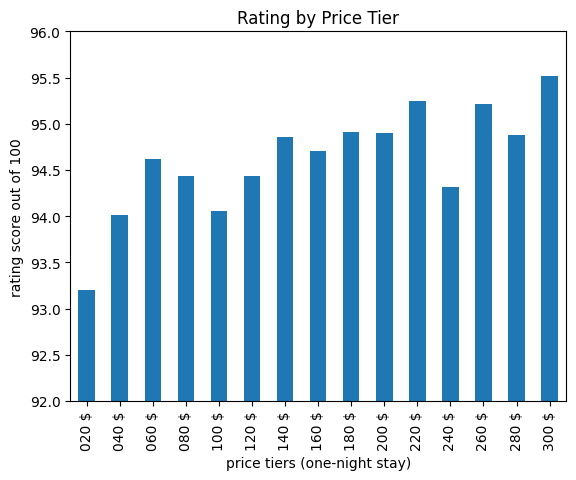

In [34]:
barplot(avg_rating_by_price, 'review_scores_rating', 92, 96, "price tiers (one-night stay)", "rating score out of 100")
plt.title("Rating by Price Tier");

### How much ratings depend on availability?

Define a dataframe to store statistics for each availability tier.

In [35]:
avg_rating_by_availability = group_by_col(df_rated, ['availability_tiers'], ['review_scores_rating'], ['mean'])
avg_rating_by_availability

review_scores_rating       gap  listings_number
availability_tiers                                                 
000 days per year              93.919355 -0.619907              186
030 days per year              95.044643  0.505381              112
060 days per year              94.479554 -0.059708              269
090 days per year              95.335878  0.796616              131
120 days per year              95.760274  1.221012              146
150 days per year              95.228700  0.689437              223
180 days per year              93.418605 -1.120657               86
210 days per year              95.543210  1.003948               81
240 days per year              96.258621  1.719359              116
270 days per year              94.205479 -0.333783              146
300 days per year              95.033195  0.493933              241
330 days per year              94.943396  0.404134              689
360 days per year              93.338255 -1.201007              745

The following chart represents the average rating scores for any availability tier.

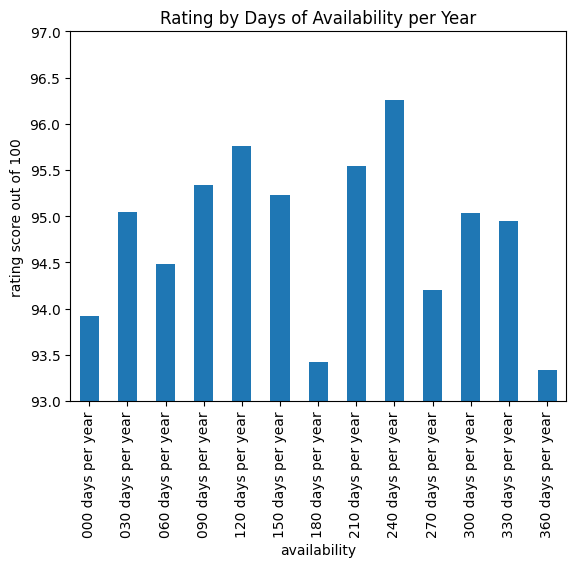

In [36]:
barplot(avg_rating_by_availability, 'review_scores_rating', 93, 97, "availability", "rating score out of 100")
plt.title("Rating by Days of Availability per Year");